In [3]:
import os, math, random, hashlib
from collections import Counter
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, ClassLabel, DatasetDict


/Users/devonwilliams/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/devonwilliams/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
URL = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
huff_all = load_dataset("json", data_files=URL, split="train")
def make_text(ex):
    h = (ex.get("headline") or "").strip()
    s = (ex.get("short_description") or "").strip()
    return {"text": (h + " [SEP] " + s).strip()}
huff_all = huff_all.map(make_text)
huff_all = huff_all.rename_column("category","label_str")
if "label" not in huff_all.column_names or not isinstance(huff_all.features["label_str"], ClassLabel):
    huff_all = huff_all.class_encode_column("label_str")
    huff_all = huff_all.rename_column("label_str","label")
label_names = huff_all.features["label"].names
print(len(huff_all), len(label_names))


Generating train split: 200853 examples [00:00, 1969395.68 examples/s]
Casting to class labels: 100%|██████████| 200853/200853 [00:00<00:00, 824591.09 examples/s]

200853 41


9.614977973568282


,label_id,count,label_name
4,24,32739,POLITICS
31,37,17827,WELLNESS
1,10,16058,ENTERTAINMENT
12,34,9887,TRAVEL
34,30,9649,STYLE & BEAUTY
32,22,8677,PARENTING
25,16,6694,HEALTHY LIVING
9,25,6314,QUEER VOICES
37,13,6226,FOOD & DRINK
11,3,5937,BUSINESS


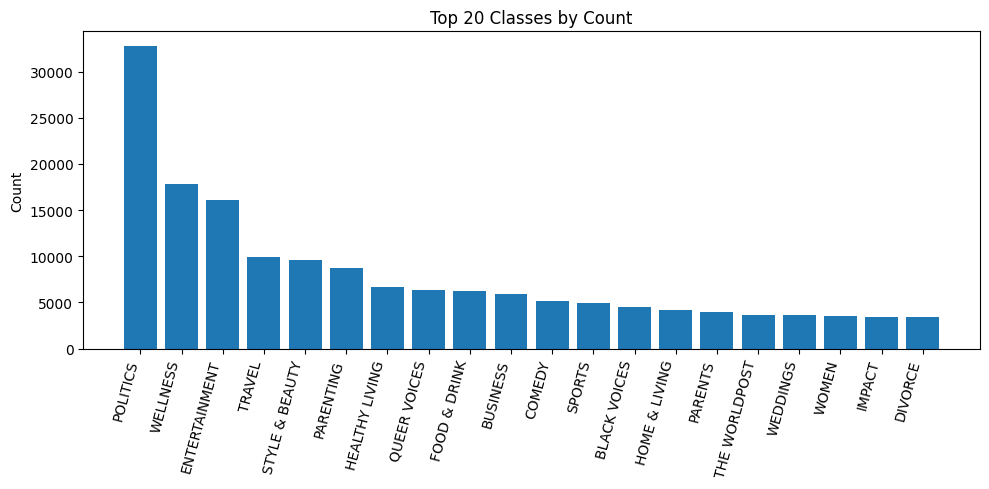

In [5]:
counts = Counter(huff_all["label"])
count_df = pd.DataFrame({"label_id": list(counts.keys()), "count": list(counts.values())}).sort_values("count", ascending=False)
count_df["label_name"] = count_df["label_id"].apply(lambda i: label_names[i])
imbalance_ratio = count_df["count"].max() / count_df["count"].median()
print(imbalance_ratio)
display(count_df.head(10))
plt.figure(figsize=(10,5))
plt.bar(count_df["label_name"][:20], count_df["count"][:20])
plt.xticks(rotation=75, ha="right")
plt.ylabel("Count")
plt.title("Top 20 Classes by Count")
plt.tight_layout()
plt.show()


{50: 29, 75: 36, 90: 50, 95: 57, 99: 68}
1 246 30.26685187674568 14.04689916977026


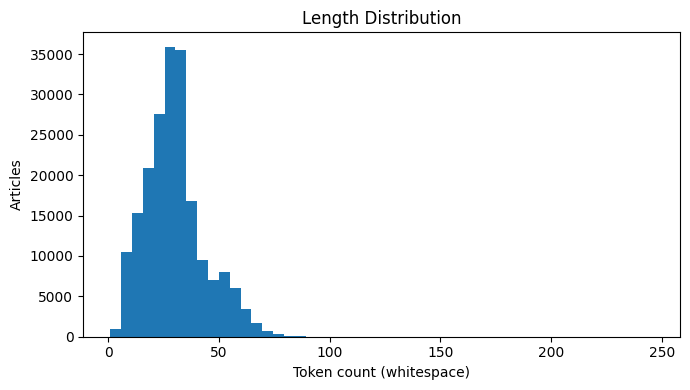

In [6]:
def rough_len(s):
    return len((s or "").split())
lens = np.array([rough_len(t) for t in huff_all["text"]])
pcts = [50,75,90,95,99]
print({p:int(np.percentile(lens,p)) for p in pcts})
print(int(lens.min()), int(lens.max()), float(lens.mean()), float(lens.std()))
plt.figure(figsize=(7,4))
plt.hist(lens, bins=50)
plt.xlabel("Token count (whitespace)")
plt.ylabel("Articles")
plt.title("Length Distribution")
plt.tight_layout()
plt.show()


In [7]:
def trunc_rate(L):
    return float((lens > L).sum())/len(lens)
candidates = [128,192,256,300,384,512]
tr = pd.DataFrame({"max_length": candidates, "truncation_rate": [trunc_rate(L) for L in candidates]})
display(tr)


,max_length,truncation_rate
0,128,0.000831
1,192,0.000060
2,256,0.000000
3,300,0.000000
4,384,0.000000
5,512,0.000000


In [8]:
def md5(s):
    return hashlib.md5((s or "").encode("utf-8")).hexdigest()
hashes = [md5(t) for t in huff_all["text"]]
dupe_counts = pd.Series(hashes).value_counts()
num_groups = int((dupe_counts > 1).sum())
print(num_groups)
if num_groups:
    dup_hash = dupe_counts[dupe_counts > 1].index[0]
    idxs = [i for i,h in enumerate(hashes) if h == dup_hash][:3]
    for i in idxs:
        ex = huff_all[i]
        print(ex["text"][:200])
        print(label_names[ex["label"]])


209
Watch The Top 9 YouTube Videos Of The Week [SEP] If you're looking to see the most popular YouTube videos of the week, look no further. Once again, we're bringing you the
TECH
Watch The Top 9 YouTube Videos Of The Week [SEP] If you're looking to see the most popular YouTube videos of the week, look no further. Once again, we're bringing you the
TECH
Watch The Top 9 YouTube Videos Of The Week [SEP] If you're looking to see the most popular YouTube videos of the week, look no further. Once again, we're bringing you the
TECH


In [9]:
k, seed = 5, 17
rng = random.Random(seed)
idxs = rng.sample(range(len(huff_all)), k)
for i in idxs:
    ex = huff_all[i]
    print("["+label_names[ex["label"]]+"] "+ex["text"][:240])
    print()


[TRAVEL] Kobe Luminarie Illuminates At Japan Festival [SEP] Christmas lights have been hung around the world, but few displays rival the stunning light show at Kobe Luminarie. The December

[IMPACT] Yasmin Altwaijri: A Saudi Scientist Tackles Mental Health and Obesity [SEP] As one of Saudi Arabia's most senior scientists, Yasmin Altwaijri leads epidemiology research at King Faisal Specialist Hospital and Research Centre in Riyadh. She'

[MEDIA] Vice Went To Prison With Obama. Now It's Going Deep Into Inmate Issues. [SEP] "It was too good an opportunity not to throw the kitchen sink at it."

[BUSINESS] Down the Talent Drain: Where Are All the Female Leaders? [SEP] The increasing influence of women is challenging us all to adapt and realign ourselves to the needs of a new society. Engaging women in the workplace, especially at the leadersh

[BUSINESS] E. Coli Outbreak Linked To Chipotle Restaurants Grows [SEP] At least 37 people have been infected by an E. coli outbreak linked to the fas

In [10]:
tmp = huff_all.train_test_split(test_size=0.15, seed=42, stratify_by_column="label")
train_val = tmp["train"].train_test_split(test_size=0.1765, seed=42, stratify_by_column="label")
ds = DatasetDict(train=train_val["train"], val=train_val["test"], test=tmp["test"])
print({k: len(v) for k,v in ds.items()})


{'train': 140592, 'val': 30133, 'test': 30128}
